## Описание задания

#### Описание задания

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (будем проверять на конверсии в покупку). Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана

 

#### Описание колонок
experimentVariant – вариант эксперимента,
version – версия приложения,
purchase – факт покупки
 

### Задача
Запустите A/A-тест
Посчитайте FPR на уровне альфа = 0.05 (ставьте подвыборки без возвращения объемом 1000). Вы увидите, что FPR >  альфа! Нам нужно наоборот – чтобы было меньше.
Найдите причины поломки сплит-системы, ориентируясь на результаты эксперимента (подсказка: найдите аномалию в версии приложения)
Напишите выводы, которые можно сделать на основе анализа результатов A/A-теста

### План решения

1. Произведем предобработку данных
2. Посчитаем конверсию (коэффициент покупок), сгруппировав данные по версии мобильного приложения (МП) и по вариану эксперемента
3. Посчитаем p-value для каждой версии МП
4. FPR (False Positive Rate) > альфа (0.05)! Нам нужно наоборот – чтобы было меньше. Исключаем из основного ДатаФрейма
5. Произведем повторные расчёты FPR
6. Вы находитесь здесь : Поломка найдена!
7. Результаты, выводы


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
from scipy import stats
import matplotlib.pyplot as plt

from tqdm.auto import tqdm


plt.style.use('ggplot')

In [2]:
df = pd.read_csv('/home/jupyter-a.chicherova-13/STATISTIC/10/hw_aa.csv', sep=';')

### Шаг 1
Проведем предобработку данных


In [3]:
df.isna().sum()

Unnamed: 0           0
uid                  0
experimentVariant    0
version              0
purchase             0
dtype: int64

In [4]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

In [5]:
# Убедимся, что вообще нужно искать ошибку, проведя А/А тест на исходных данных

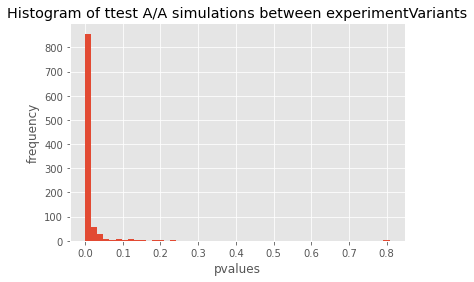

0.945

In [6]:

# Запуск  A/A теста
simulations = 1000
n_s = 1000
res = []
for i in tqdm(range(simulations)):
    s1 = df[df.experimentVariant == 1]['purchase'].sample(n_s, replace = False).values
    s2 = df[df.experimentVariant == 0]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations between experimentVariants")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Это наш случай - A/A-тест не сходится

### Шаг 2
Посчитаем конверсию (коэффициент покупок), сгруппировав данные по версии мобильного приложения (МП) и по вариану эксперемента


In [7]:
df.groupby(['version', 'experimentVariant'])\
    .agg({'purchase':'mean', 'Unnamed: 0':'count'})\
    .rename({'purchase':'conversion'})\
    .reset_index()

,version,experimentVariant,purchase,Unnamed: 0
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


### Уже на данном этапе видно,  где именно причины поломки (version == v2.8.0, experimentVariant==0 )


### Шаг 3
Посчитайте pvalue для каждой версии МП
Найдите версии, где pvalue < 0.05
Исключите версию с pvalue < 0.05 из основного датафрейма

### В качестве статистического метода используем t-test

In [8]:
df.groupby(['version', 'experimentVariant'])\
    .agg({'purchase':'mean', 'Unnamed: 0':'count'})\
    .rename({'purchase':'conversion'})\
    .reset_index()

,version,experimentVariant,purchase,Unnamed: 0
0,v2.8.0,0,0.000993,41283
1,v2.8.0,1,0.045606,41552
2,v2.9.0,0,0.074658,11921
3,v2.9.0,1,0.071304,12033
4,v3.7.4.0,0,0.059943,4204
5,v3.7.4.0,1,0.063018,4221
6,v3.8.0.0,0,0.057604,5694
7,v3.8.0.0,1,0.062848,6110


In [9]:
stats.ttest_ind(df[(df.version=='v3.8.0.0') &(df.experimentVariant==1)]['purchase'],\
                df[(df.version=='v3.8.0.0') &(df.experimentVariant==0)]['purchase'])

Ttest_indResult(statistic=1.1956188950206779, pvalue=0.23186933664059722)

In [10]:
stats.ttest_ind(df[(df.version=='v3.7.4.0') &(df.experimentVariant==1)]['purchase'],\
                df[(df.version=='v3.7.4.0') &(df.experimentVariant==0)]['purchase'])

Ttest_indResult(statistic=0.5874925850487471, pvalue=0.5568886771079735)

In [11]:
stats.ttest_ind(df[(df.version=='v2.9.0') &(df.experimentVariant==1)]['purchase'],\
                df[(df.version=='v2.9.0') &(df.experimentVariant==0)]['purchase'])

Ttest_indResult(statistic=-0.9979597634962479, pvalue=0.31830895167207446)

In [12]:
stats.ttest_ind(df[(df.version=='v2.8.0') &(df.experimentVariant==1)]['purchase'],\
                df[(df.version=='v2.8.0') &(df.experimentVariant==0)]['purchase'])

Ttest_indResult(statistic=42.963540840360324, pvalue=0.0)

### pvalue=0.0, это то, что мы искали

### Шаг 4
Произведем повторные расчёты FPR

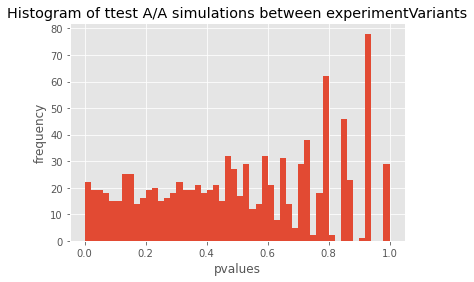

0.049

In [13]:

# Запуск  A/A теста
simulations = 1000
n_s = 1000
res = []
for i in tqdm(range(simulations)):
    s1 = df[(df.experimentVariant == 1) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    s2 = df[(df.experimentVariant == 0) & (df.version != 'v2.8.0')]['purchase'].sample(n_s, replace = False).values
    res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue

plt.hist(res, bins = 50)
plt.style.use('ggplot')
plt.xlabel('pvalues')
plt.ylabel('frequency')
plt.title("Histogram of ttest A/A simulations between experimentVariants")
plt.show()

# Проверяем, что количество ложноположительных случаев не превышает альфа
sum(np.array(res) <0.05) / simulations

### Шаг 5
Вы находитесь здесь : Поломка найдена! 

### Шаг 6. Поговорим о вечном

Корректно ли работает система сплитования? 
- Нет, поломка находится в версии "v2.8.0" в эксперементальной группе "0" 

Завышенный FPR / Техническая реализация
    Основные причины кроются в сломанном сплит-алгоритме.
    Причины необходимо искать на стороне, где реализован скрипт и его запуск.
    
    
 К сожалению, для более глубокой оценки данных недостаточно, причиной может быть что угодно: 
- Долгое ожидание ответа сервера по присвоению id эксперимента и сплита
- Приоритет той или иной группе
- Не на всех страницах или кейсах реализован сплит-алгоритм
- Банально «сломан» рандом (например, неправильно посчитан остаток от деления по сумме хеша)
- Поиск возможной причины
- Дисбаланс в группах по описательным признакам


### Причины необходимо искать на стороне, где реализован скрипт и его запуск
